---

# KDDCUP99

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from time import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle

import pandas as pd
import os
import sys

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

from load_data import get_DoH_INV
from FGAN_MODEL import FenceGAN

In [2]:
def meanAUC_PRAUC(auc_list, pr_list, name, SPACE_AUC, SPACE_AUPRC):
    print('AUC:')
    print(auc_list)
    print('**************')
    print('PR AUC:')
    print(pr_list)
    print('**************')
    
    
    AUC_Frame = pd.DataFrame(auc_list, columns = [name])
    PR_AUC_Frame = pd.DataFrame(pr_list, columns = [name])
    
    AU_NAME = f'{name}.csv'
    
    AUC_Frame.to_csv(os.path.join(SPACE_AUC, AU_NAME), index=False)
    PR_AUC_Frame.to_csv(os.path.join(SPACE_AUPRC, AU_NAME), index=False)
    
    AUC_Frame = list(AUC_Frame[name])

    N = len(AUC_Frame)
    mean_auc = np.mean(AUC_Frame)
    std_auc = np.std(AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    print('**************')
    
    PR_AUC_Frame = list(PR_AUC_Frame[name])

    N = len(PR_AUC_Frame)
    mean_auc = np.mean(PR_AUC_Frame)
    std_auc = np.std(PR_AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('PR AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')

In [3]:
batch_size = 1024

WORK_SPACE = '../Dataset'
DATASET_AREA = 'CIRA-CIC-DoHBrw-2020'

SPACE_MODELS = './models'
SPACE_AUC = './auc'
SPACE_AUPRC = './auprc'

for n in (SPACE_MODELS, SPACE_AUC, SPACE_AUPRC):
    if not os.path.exists(n):
        os.mkdir(n)
        
FILE_3 = 'l2-benign.csv'
FILE_4 = 'l2-malicious.csv'

DATASET = 'DoH_INV'

PATH_B = os.path.join(WORK_SPACE, DATASET_AREA, FILE_3)
PATH_M = os.path.join(WORK_SPACE, DATASET_AREA, FILE_4)

In [4]:
dataset = get_DoH_INV(PATH_B, PATH_M, seed, show=True)

249836 normal records, 19807 anormal records
We use 9903 anomalous records
-----------------------------------------------------------------------------------------
There are 184444 records in training set
Training set is composed by 184444 normal records and 0 abnormal records
-----------------------------------------------------------------------------------------
There are 18073 records in validation set
Validation set is composed by 15598 normal records and 2475 abnormal records
-----------------------------------------------------------------------------------------
There are 57221 records in test set
Test set is composed by 49794 normal records and 7427 abnormal records


In [5]:
nc = dataset['x_train'].shape[1]
z_dim = 32
gamma = 0.1
alpha = 0.5 
beta = 30 
_power = 2
v_freq = 4

g_objective_anneal = 1
repeat = 4 
baseline = 0.5

#### Mean AUC and standard deviation after seven runs

Iteration: 1
Epoch #1: Loss: 0.7400
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.106 | g_loss: 1.6042
[INFO] Training phase... Elapsed time: 4904 seconds



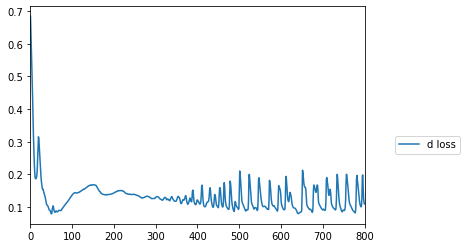

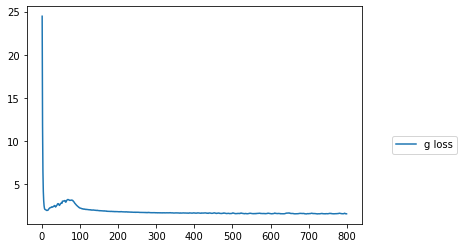

PR AUC: 0.36


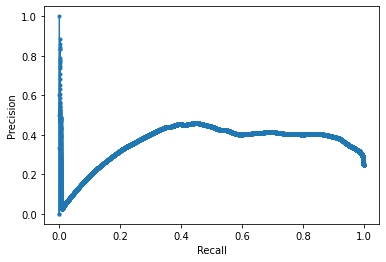

AUC: 0.88
Iteration: 2
Epoch #1: Loss: 0.7522
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.110 | g_loss: 1.6158
[INFO] Training phase... Elapsed time: 4870 seconds



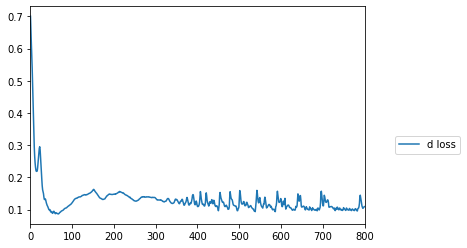

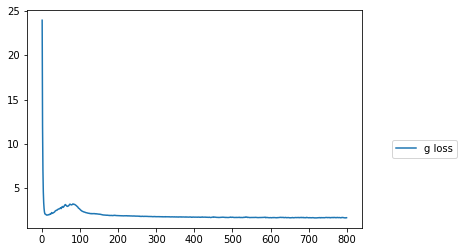

PR AUC: 0.37


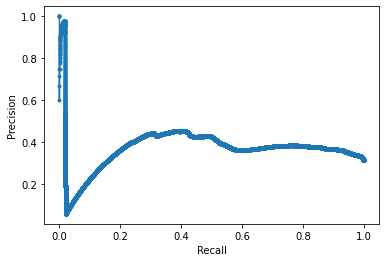

AUC: 0.87
Iteration: 3
Epoch #1: Loss: 0.7642
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.099 | g_loss: 1.6399
[INFO] Training phase... Elapsed time: 4125 seconds



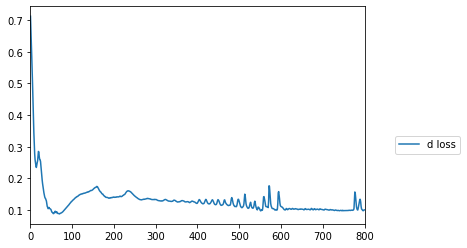

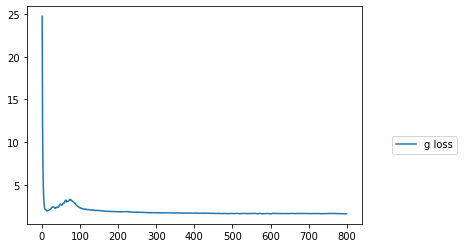

PR AUC: 0.43


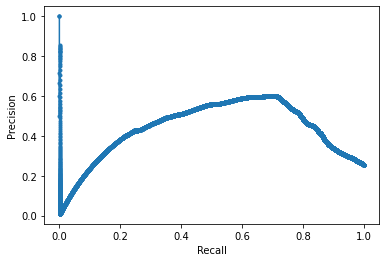

AUC: 0.90
Iteration: 4
Epoch #1: Loss: 0.7776
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.098 | g_loss: 1.6527
[INFO] Training phase... Elapsed time: 3985 seconds



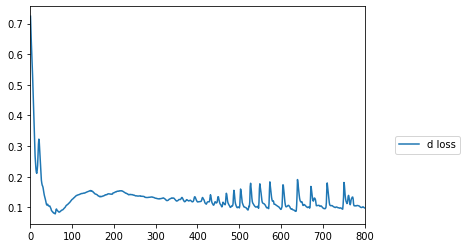

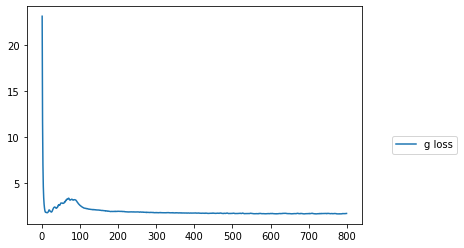

PR AUC: 0.49


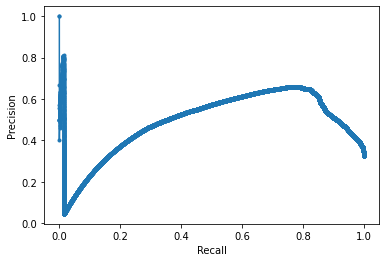

AUC: 0.93
Iteration: 5
Epoch #1: Loss: 0.7699
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.159 | g_loss: 1.6830
[INFO] Training phase... Elapsed time: 4163 seconds



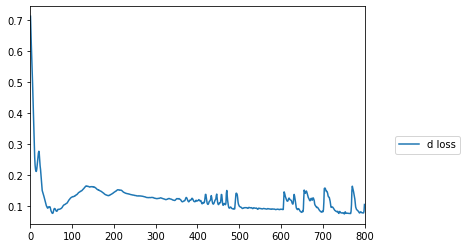

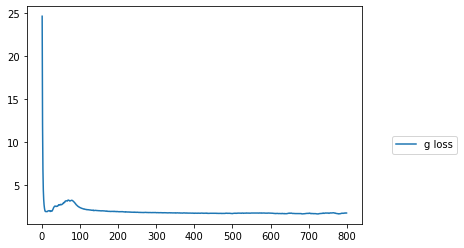

PR AUC: 0.53


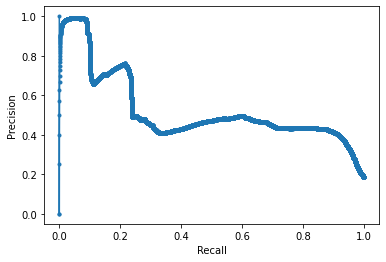

AUC: 0.90
Iteration: 6
Epoch #1: Loss: 0.7328
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.102 | g_loss: 1.6489
[INFO] Training phase... Elapsed time: 4974 seconds



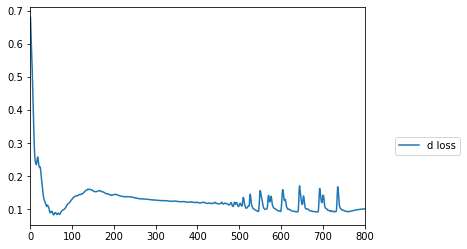

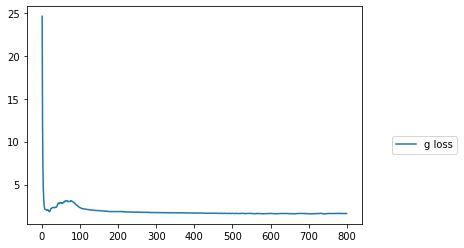

PR AUC: 0.48


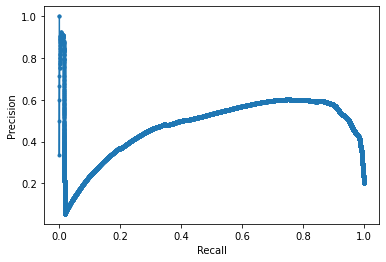

AUC: 0.93
Iteration: 7
Epoch #1: Loss: 0.7190
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.100 | g_loss: 1.6142
[INFO] Training phase... Elapsed time: 5341 seconds



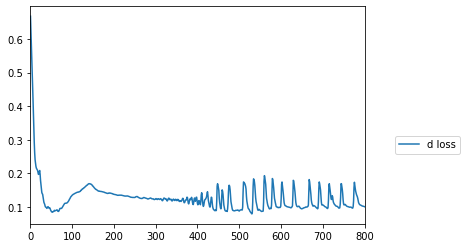

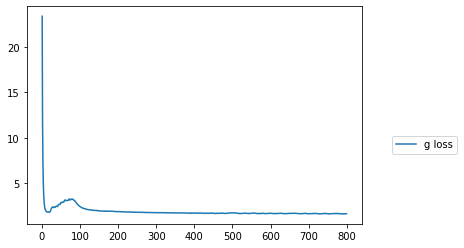

PR AUC: 0.42


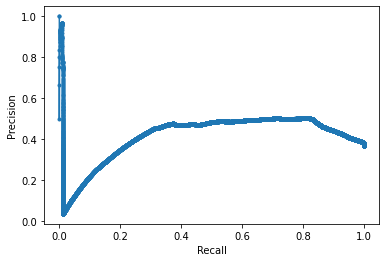

AUC: 0.91
Iteration: 8
Epoch #1: Loss: 0.7454
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.130 | g_loss: 1.6376
[INFO] Training phase... Elapsed time: 5579 seconds



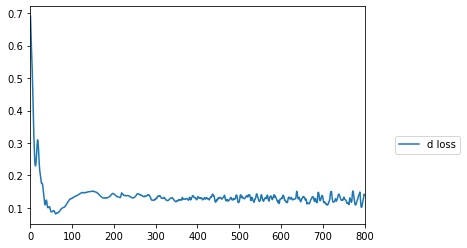

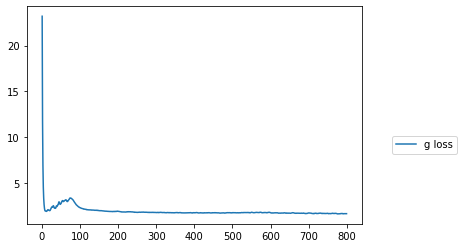

PR AUC: 0.39


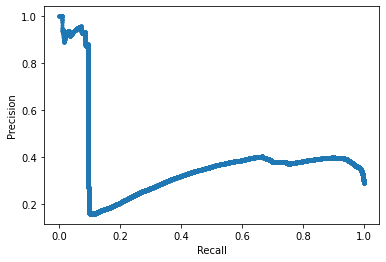

AUC: 0.86
Iteration: 9
Epoch #1: Loss: 0.7409
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.118 | g_loss: 1.6061
[INFO] Training phase... Elapsed time: 5490 seconds



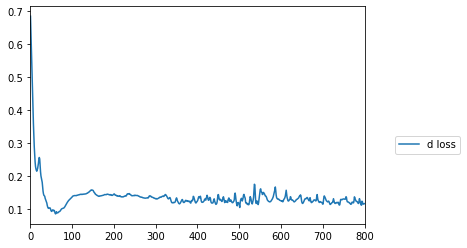

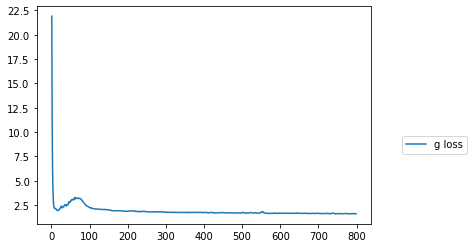

PR AUC: 0.37


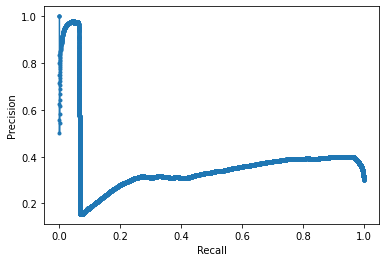

AUC: 0.86
Iteration: 10
Epoch #1: Loss: 0.7189
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.094 | g_loss: 1.6531
[INFO] Training phase... Elapsed time: 5358 seconds



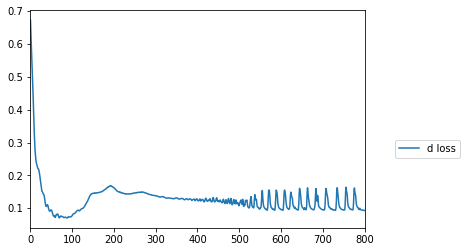

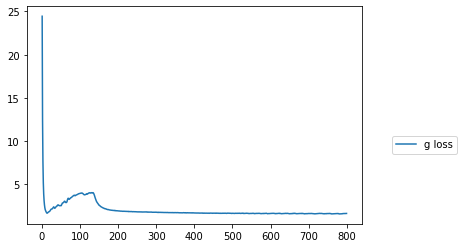

PR AUC: 0.50


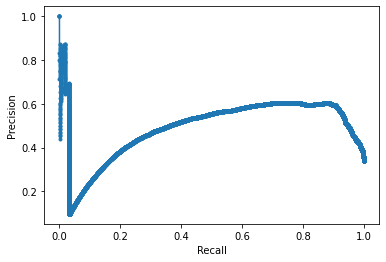

AUC: 0.93
Iteration: 11
Epoch #1: Loss: 0.7673
[INFO] Starting training phase...
Epoch [490/800] | d_loss: 0.108 | g_loss: 1.6302

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [800/800] | d_loss: 0.092 | g_loss: 1.660
[INFO] Training phase... Elapsed time: 5397 seconds



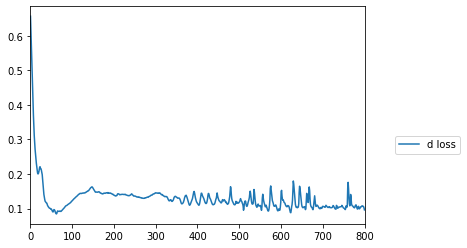

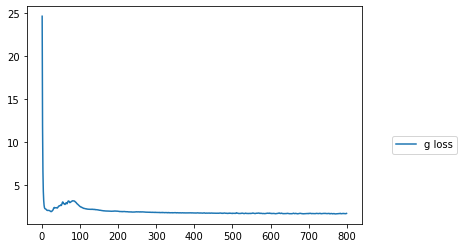

PR AUC: 0.33


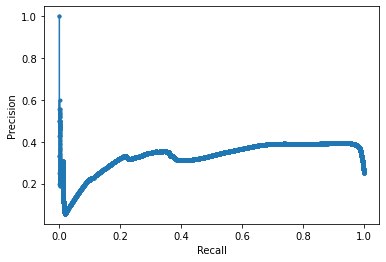

AUC: 0.87
Iteration: 13
Epoch #1: Loss: 0.7713
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.105 | g_loss: 1.6400
[INFO] Training phase... Elapsed time: 5360 seconds



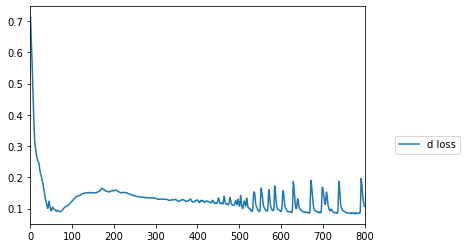

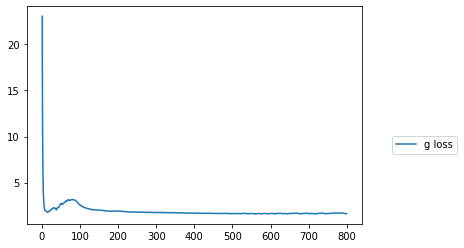

PR AUC: 0.38


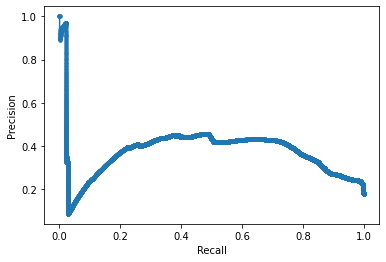

AUC: 0.86
Iteration: 14
Epoch #1: Loss: 0.7190
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.124 | g_loss: 1.6655
[INFO] Training phase... Elapsed time: 5249 seconds



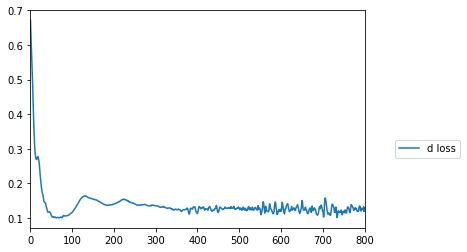

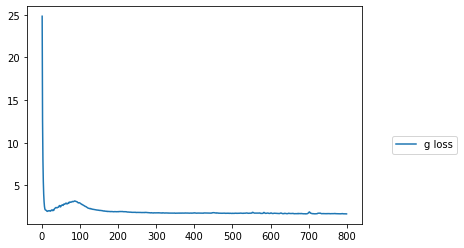

PR AUC: 0.62


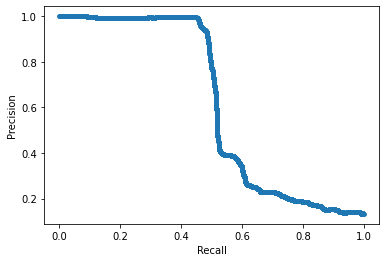

AUC: 0.76
Iteration: 15
Epoch #1: Loss: 0.7347
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.119 | g_loss: 1.6218
[INFO] Training phase... Elapsed time: 5224 seconds



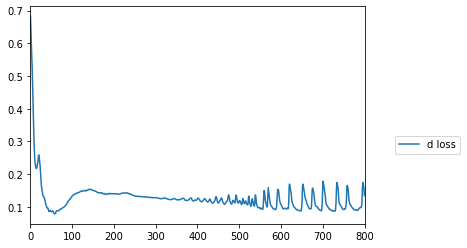

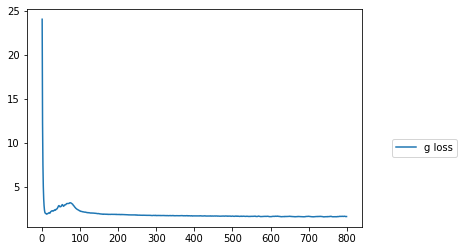

PR AUC: 0.36


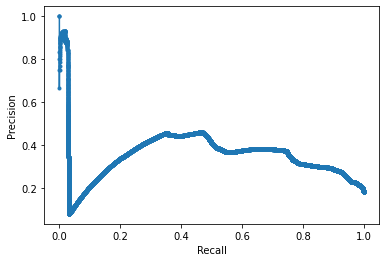

AUC: 0.84
Iteration: 16
Epoch #1: Loss: 0.7158
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.106 | g_loss: 1.6650
[INFO] Training phase... Elapsed time: 4786 seconds



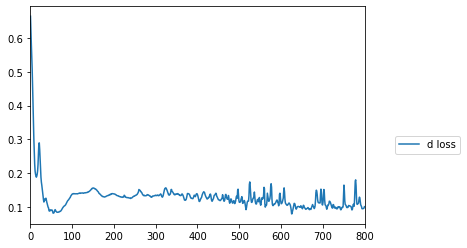

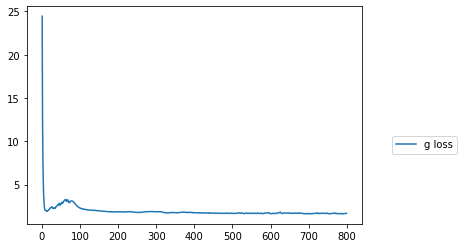

PR AUC: 0.44


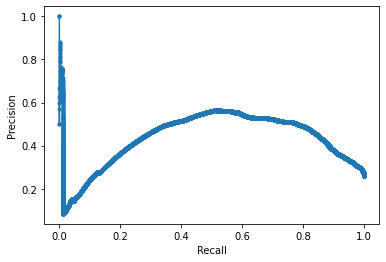

AUC: 0.90
Iteration: 17
Epoch #1: Loss: 0.7443
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.105 | g_loss: 1.6585
[INFO] Training phase... Elapsed time: 4695 seconds



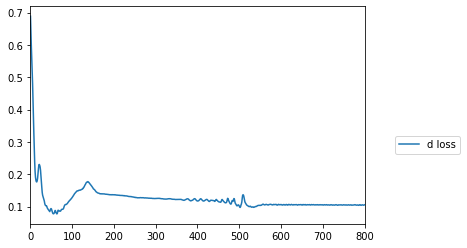

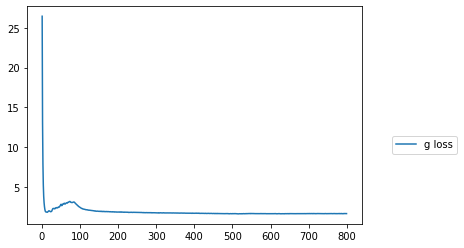

PR AUC: 0.38


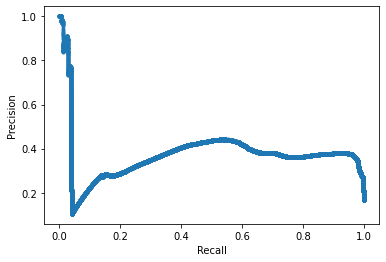

AUC: 0.87
Iteration: 18
Epoch #1: Loss: 0.7371
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.091 | g_loss: 1.6614
[INFO] Training phase... Elapsed time: 4655 seconds



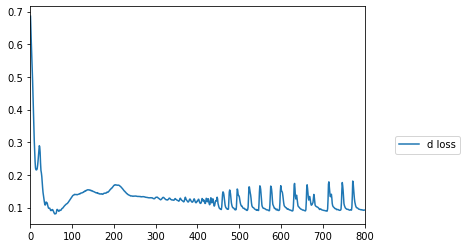

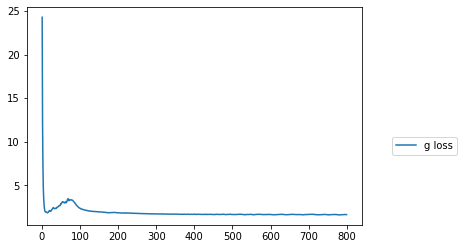

PR AUC: 0.39


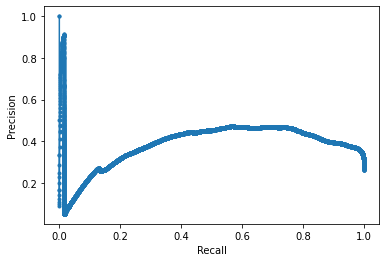

AUC: 0.89
Iteration: 19
Epoch #1: Loss: 0.7829
[INFO] Starting training phase...
Epoch [310/800] | d_loss: 0.122 | g_loss: 1.7615*****************************************************************************************
[INFO] Exiting from training early

[INFO] Training phase... Elapsed time: 1798 seconds



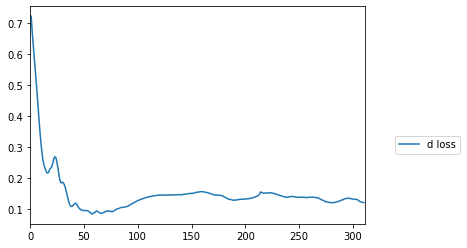

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [6]:
n_runs = 20
auc_list = []
n_epochs = 800
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_DoH_INV(PATH_B, PATH_M, seed*(i+1), show=False)
    
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_train']).to(device), 
                                              torch.tensor(dataset['y_train'].to_numpy()).to(device))
    
    train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']).to(device), 
                                              torch.tensor(dataset['y_val'].to_numpy()).to(device))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']).to(device), 
                                              torch.tensor(dataset['y_test'].to_numpy()).to(device))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = FenceGAN(nc, z_dim, gamma, alpha, beta, _power, v_freq, g_objective_anneal, repeat, baseline, device)
    
    d_losses, g_losses = trainer.train(train_loader, test_loader, val_loader, batch_size, n_epochs)
    
    # Save models
    NAME_D = f'D_FGAN_{DATASET}_{i}.ckpt'
    NAME_G = f'G_FGAN_{DATASET}_{i}.ckpt'
    
    torch.save(trainer.D.state_dict(), os.path.join(SPACE_MODELS, NAME_D))
    torch.save(trainer.G.state_dict(), os.path.join(SPACE_MODELS, NAME_G))
    
    _auc, pr_auc = trainer.predict(test_loader)
    print(f'AUC: {_auc:.2f}')
    auc_list.append(_auc)
    pr_list.append(pr_auc)

In [10]:
meanAUC_PRAUC(auc_list, pr_list, 'FGAN_DoH_INV', SPACE_AUC, SPACE_AUPRC)

AUC:
[0.8789872102603591, 0.8735853017785911, 0.8999529495478555, 0.930747960174078, 0.8964757407223023, 0.9274789120539758, 0.9067289087780581, 0.8625931026484833, 0.8645968502117779, 0.9320326390751168, 0.9275417142215533, 0.8664437458091441, 0.8601761608709803, 0.7646684885690266, 0.8445359929361101, 0.9040351242406177, 0.8724887130101913, 0.892344669273978]
**************
PR AUC:
[0.3628727427020757, 0.37326496131489073, 0.4341868915551521, 0.49164883474823623, 0.5262954794251893, 0.4791868832718023, 0.4219239588575584, 0.38744981674178247, 0.3736064024517167, 0.4982418966319123, 0.4748230359608331, 0.332089089584609, 0.3773543961684691, 0.6150092196307974, 0.3561357787986358, 0.435340690980455, 0.3752671405599346, 0.3917990254132816]
**************
AUC
0.88 +/- 0.02
95% confidence level, average auc would be between 0.87 and 0.90
**************
PR AUC
0.43 +/- 0.03
95% confidence level, average auc would be between 0.40 and 0.46


Iteration: 19
Epoch #1: Loss: 0.7284
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.102 | g_loss: 1.6359
[INFO] Training phase... Elapsed time: 4504 seconds



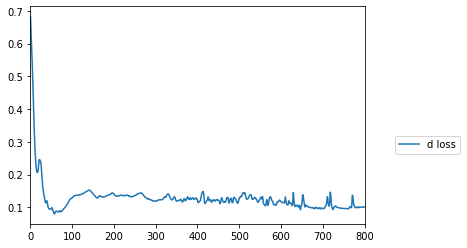

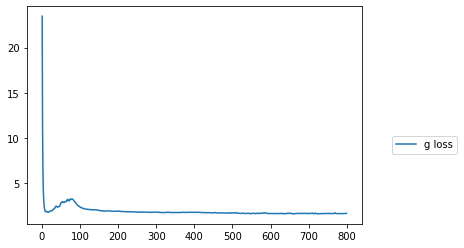

PR AUC: 0.77


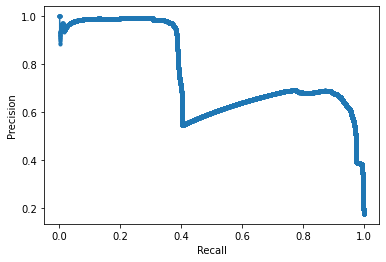

AUC: 0.96
Iteration: 20
Epoch #1: Loss: 0.7669
[INFO] Starting training phase...
Epoch [800/800] | d_loss: 0.104 | g_loss: 1.6389
[INFO] Training phase... Elapsed time: 4769 seconds



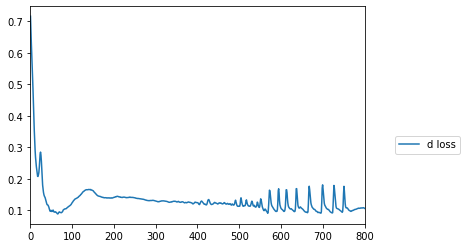

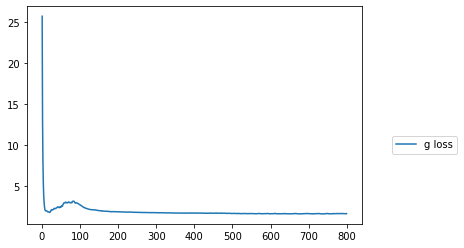

PR AUC: 0.34


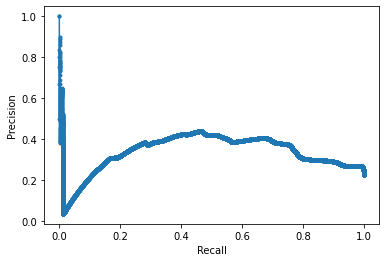

AUC: 0.85


In [12]:
for i in range(18, n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_DoH_INV(PATH_B, PATH_M, seed*(i+1), show=False)
    
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_train']).to(device), 
                                              torch.tensor(dataset['y_train'].to_numpy()).to(device))
    
    train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']).to(device), 
                                              torch.tensor(dataset['y_val'].to_numpy()).to(device))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']).to(device), 
                                              torch.tensor(dataset['y_test'].to_numpy()).to(device))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = FenceGAN(nc, z_dim, gamma, alpha, beta, _power, v_freq, g_objective_anneal, repeat, baseline, device)
    
    d_losses, g_losses = trainer.train(train_loader, test_loader, val_loader, batch_size, n_epochs)
    
    # Save models
    NAME_D = f'D_FGAN_{DATASET}_{i}.ckpt'
    NAME_G = f'G_FGAN_{DATASET}_{i}.ckpt'
    
    torch.save(trainer.D.state_dict(), os.path.join(SPACE_MODELS, NAME_D))
    torch.save(trainer.G.state_dict(), os.path.join(SPACE_MODELS, NAME_G))
    
    _auc, pr_auc = trainer.predict(test_loader)
    print(f'AUC: {_auc:.2f}')
    auc_list.append(_auc)
    pr_list.append(pr_auc)

In [13]:
auc_list

[0.8789872102603591,
 0.8735853017785911,
 0.8999529495478555,
 0.930747960174078,
 0.8964757407223023,
 0.9274789120539758,
 0.9067289087780581,
 0.8625931026484833,
 0.8645968502117779,
 0.9320326390751168,
 0.9275417142215533,
 0.8664437458091441,
 0.8601761608709803,
 0.7646684885690266,
 0.8445359929361101,
 0.9040351242406177,
 0.8724887130101913,
 0.892344669273978,
 0.9605825212207674,
 0.8509231387294378]

In [14]:
meanAUC_PRAUC(auc_list, pr_list, 'FGAN_DoH_INV', SPACE_AUC, SPACE_AUPRC)

AUC:
[0.8789872102603591, 0.8735853017785911, 0.8999529495478555, 0.930747960174078, 0.8964757407223023, 0.9274789120539758, 0.9067289087780581, 0.8625931026484833, 0.8645968502117779, 0.9320326390751168, 0.9275417142215533, 0.8664437458091441, 0.8601761608709803, 0.7646684885690266, 0.8445359929361101, 0.9040351242406177, 0.8724887130101913, 0.892344669273978, 0.9605825212207674, 0.8509231387294378]
**************
PR AUC:
[0.3628727427020757, 0.37326496131489073, 0.4341868915551521, 0.49164883474823623, 0.5262954794251893, 0.4791868832718023, 0.4219239588575584, 0.38744981674178247, 0.3736064024517167, 0.4982418966319123, 0.4748230359608331, 0.332089089584609, 0.3773543961684691, 0.6150092196307974, 0.3561357787986358, 0.435340690980455, 0.3752671405599346, 0.3917990254132816, 0.7688026607691021, 0.33773885361883865]
**************
AUC
0.89 +/- 0.02
95% confidence level, average auc would be between 0.87 and 0.90
**************
PR AUC
0.44 +/- 0.05
95% confidence level, average auc wo

---